In [1]:

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN  # Importing different SMOTE techniques
from sklearn.model_selection import cross_val_score  # For cross-validation


# Example path — replace with your actual file path in your Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/Fraud_Detection/bank_transactions_dataset.csv'

# Load CSV
df = pd.read_csv(file_path)


In [2]:
# Simulate 'is_fraud' labels based on thresholds
df['is_fraud'] = 0
df.loc[df['TransactionAmount'] > 1000, 'is_fraud'] = 1
df.loc[df['LoginAttempts'] > 3, 'is_fraud'] = 1
df.loc[df['TransactionDuration'] > 250, 'is_fraud'] = 1

# Dataset Overview
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [3]:
# Check class balance
fraud_counts = df['is_fraud'].value_counts(normalize=True) * 100
print("\nFraud class distribution (%):\n", fraud_counts)


Fraud class distribution (%):
 is_fraud
0    87.898089
1    12.101911
Name: proportion, dtype: float64


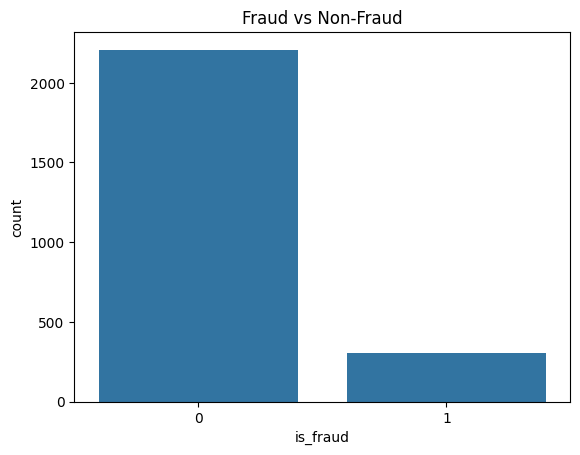

In [4]:
# Visualization - Fraud Distribution
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs Non-Fraud')
plt.show()


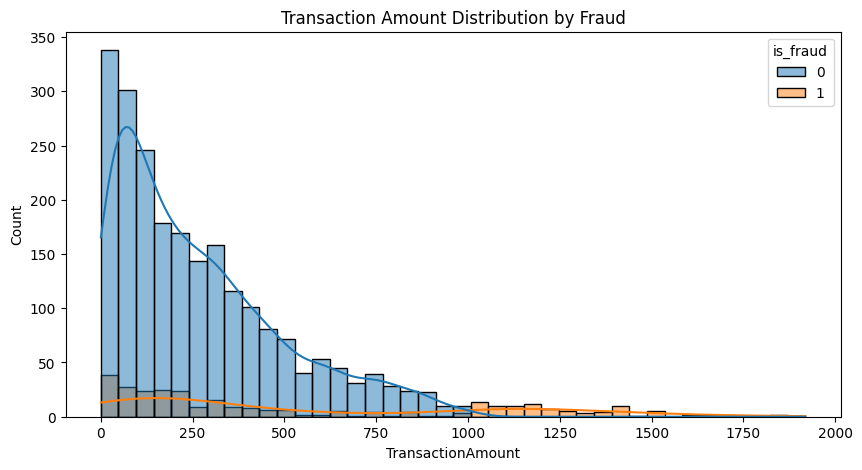

In [5]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='TransactionAmount', hue='is_fraud', bins=40, kde=True)
plt.title('Transaction Amount Distribution by Fraud')
plt.show()

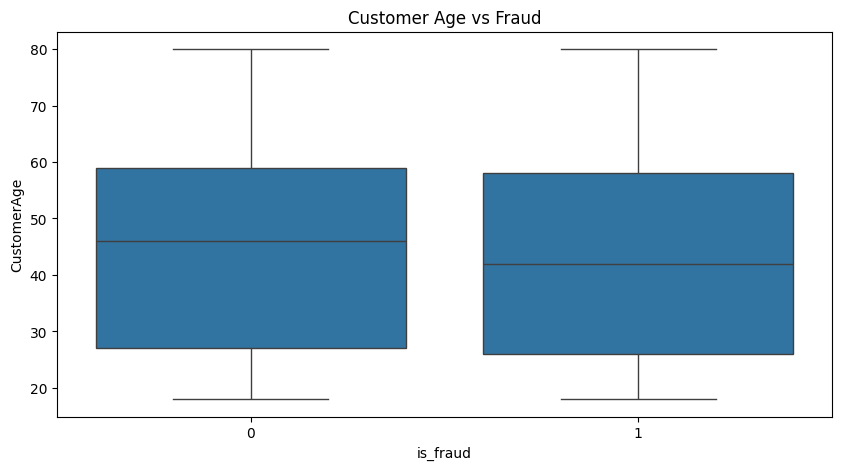

In [6]:
# Customer Age vs Fraud
plt.figure(figsize=(10,5))
sns.boxplot(x='is_fraud', y='CustomerAge', data=df)
plt.title('Customer Age vs Fraud')
plt.show()

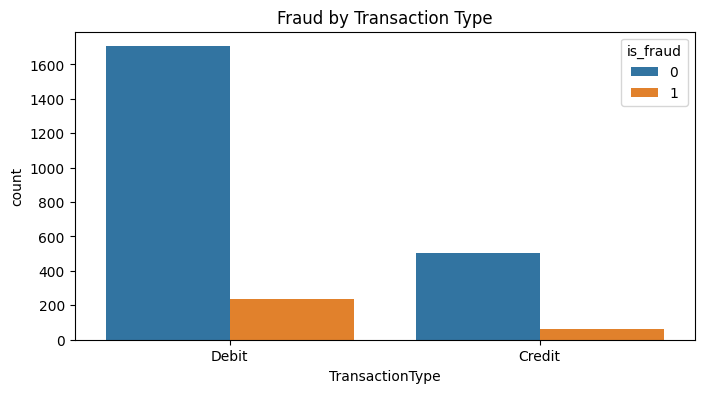

In [7]:
# Fraud by Transaction Type
plt.figure(figsize=(8,4))
sns.countplot(x='TransactionType', hue='is_fraud', data=df)
plt.title('Fraud by Transaction Type')
plt.show()

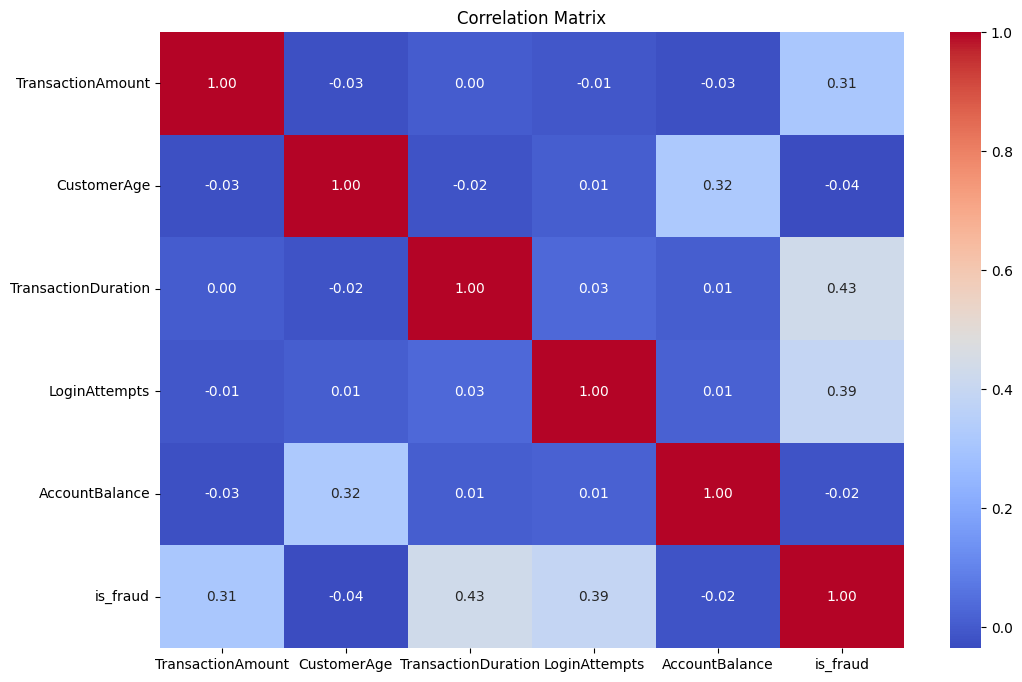

In [8]:
# Correlation Heatmap
df_numeric = df.select_dtypes(include=np.number)
plt.figure(figsize=(12,8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Drop Unused Columns
columns_to_drop = [
    'TransactionID', 'AccountID', 'TransactionDate',
    'PreviousTransactionDate', 'IP Address', 'DeviceID'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Encode Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [10]:
# Split Data
from sklearn.model_selection import train_test_split
X = df_encoded.drop('is_fraud', axis=1)
y = df_encoded['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# Apply SMOTE to balance classes in training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [12]:
# Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)

print("🔍 Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

🔍 Random Forest Accuracy: 0.9940357852882704
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       435
           1       0.96      1.00      0.98        68

    accuracy                           0.99       503
   macro avg       0.98      1.00      0.99       503
weighted avg       0.99      0.99      0.99       503



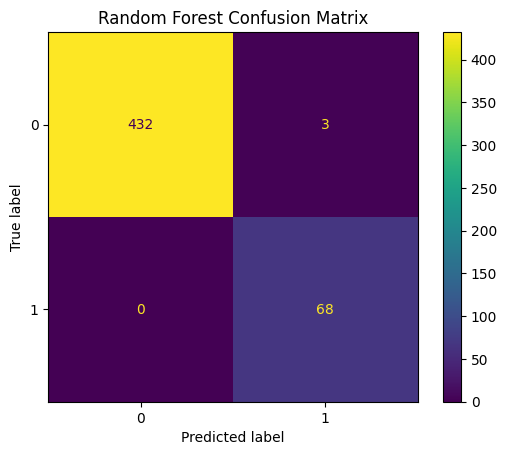

In [13]:
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()


In [14]:
# ROC Curve - Random Forest
from sklearn.metrics import roc_curve, auc # Importing roc_curve and auc
rf_probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

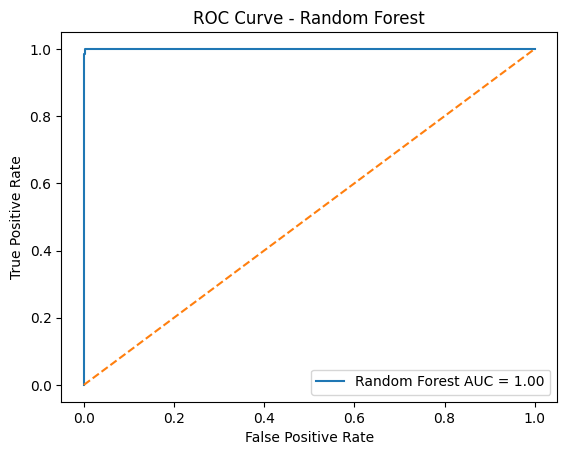

In [15]:
plt.plot(fpr, tpr, label='Random Forest AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

In [16]:
# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
lr_pred = lr.predict(X_test)

print("🔍 Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


🔍 Logistic Regression Accuracy: 0.9105367793240556
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       435
           1       0.68      0.65      0.66        68

    accuracy                           0.91       503
   macro avg       0.81      0.80      0.81       503
weighted avg       0.91      0.91      0.91       503



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


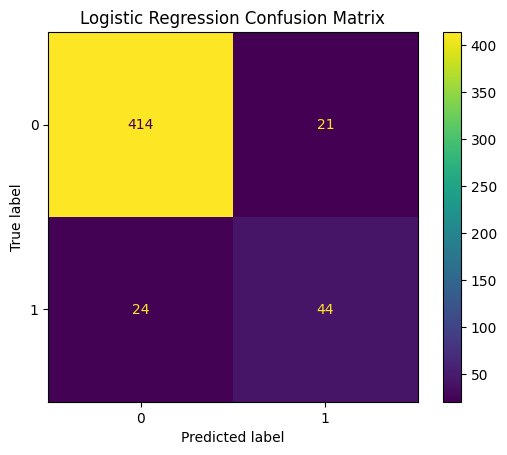

In [17]:
# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_lr).plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()


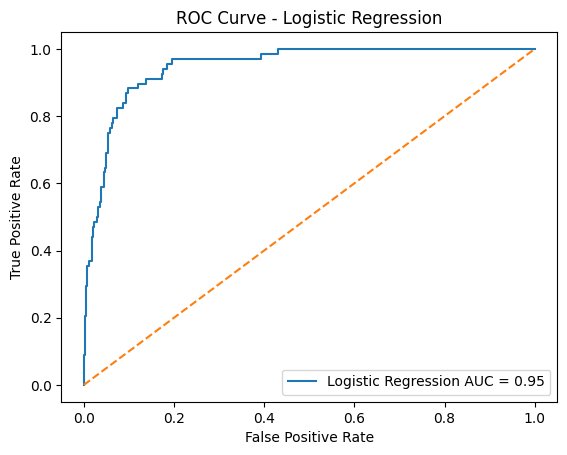

In [18]:
# ROC Curve - Logistic Regression
lr_probs = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression AUC = %0.2f' % roc_auc_lr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


🔍 SVM Accuracy: 0.7554671968190855
              precision    recall  f1-score   support

           0       0.92      0.78      0.85       435
           1       0.29      0.57      0.39        68

    accuracy                           0.76       503
   macro avg       0.61      0.68      0.62       503
weighted avg       0.84      0.76      0.79       503



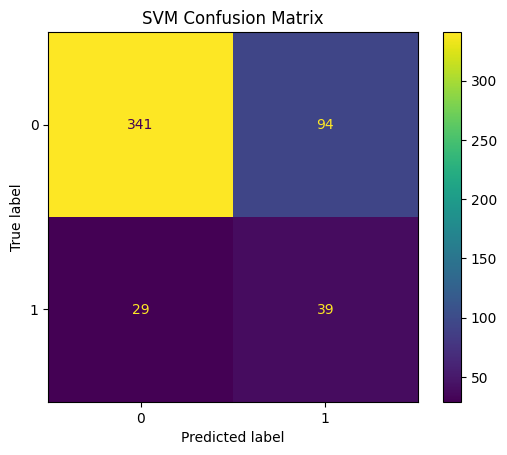

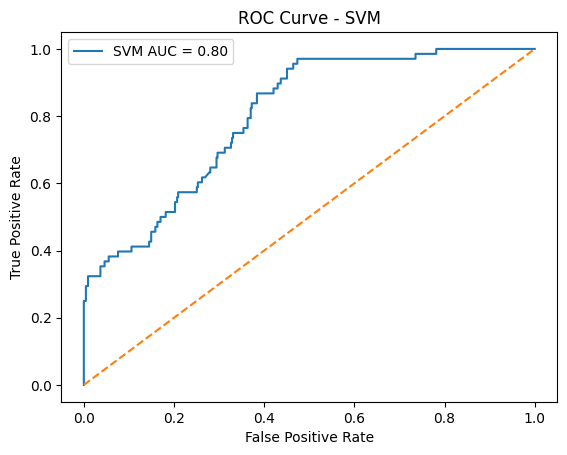

In [19]:
# SVM Model
from sklearn.svm import SVC

# Train SVM with probability estimates enabled
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_res, y_train_res)

# Predictions
svm_pred = svm.predict(X_test)

# Evaluation
print("🔍 SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

# Confusion Matrix - SVM
cm_svm = confusion_matrix(y_test, svm_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot()
plt.title('SVM Confusion Matrix')
plt.show()

# ROC Curve - SVM
svm_probs = svm.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.plot(fpr_svm, tpr_svm, label='SVM AUC = %0.2f' % roc_auc_svm)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:18:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 XGBoost Accuracy: 0.9920477137176938
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       435
           1       0.94      1.00      0.97        68

    accuracy                           0.99       503
   macro avg       0.97      1.00      0.98       503
weighted avg       0.99      0.99      0.99       503



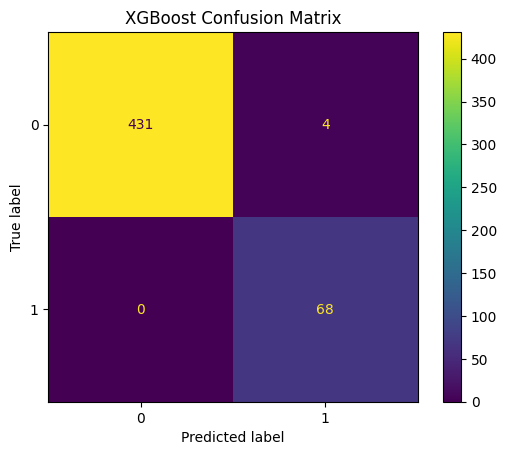

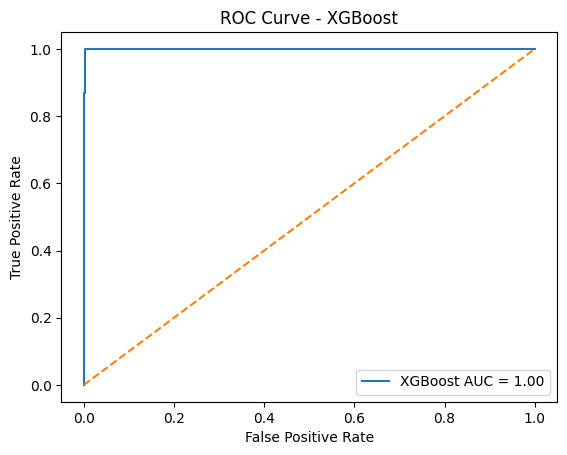

In [20]:
!pip install -q xgboost

from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

xgb_pred = xgb.predict(X_test)

print("🔍 XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

# ROC Curve
xgb_probs = xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC = %0.2f' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()


🔍 KNN Accuracy: 0.8508946322067594
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       435
           1       0.47      0.75      0.58        68

    accuracy                           0.85       503
   macro avg       0.71      0.81      0.74       503
weighted avg       0.89      0.85      0.86       503



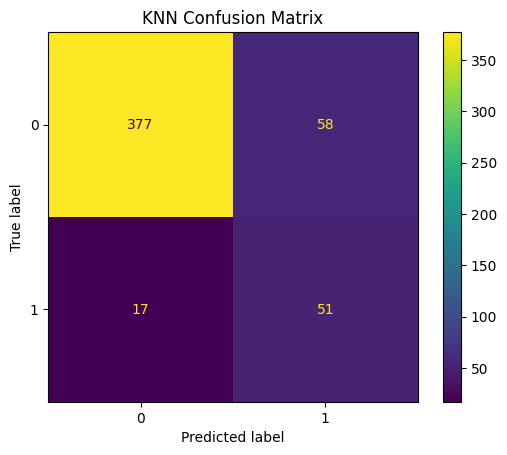

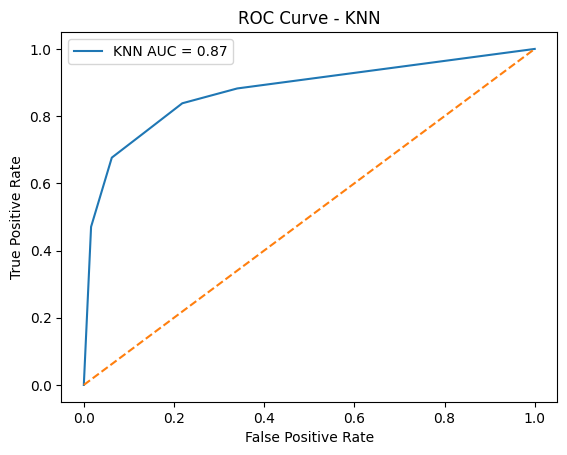

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)

knn_pred = knn.predict(X_test)

print("🔍 KNN Accuracy:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, knn_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()
plt.title('KNN Confusion Matrix')
plt.show()

# ROC Curve
knn_probs = knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, label='KNN AUC = %0.2f' % roc_auc_knn)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)

gb_pred = gb.predict(X_test)
print("🔍 Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))


🔍 Gradient Boosting Accuracy: 0.9940357852882704
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       435
           1       0.96      1.00      0.98        68

    accuracy                           0.99       503
   macro avg       0.98      1.00      0.99       503
weighted avg       0.99      0.99      0.99       503



🔍 Gradient Boosting Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       435
           1       1.00      1.00      1.00        68

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



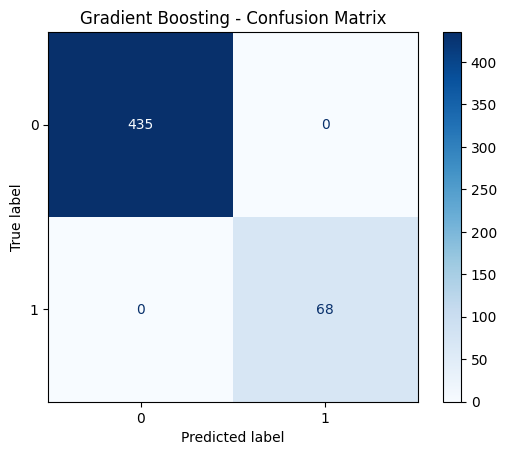

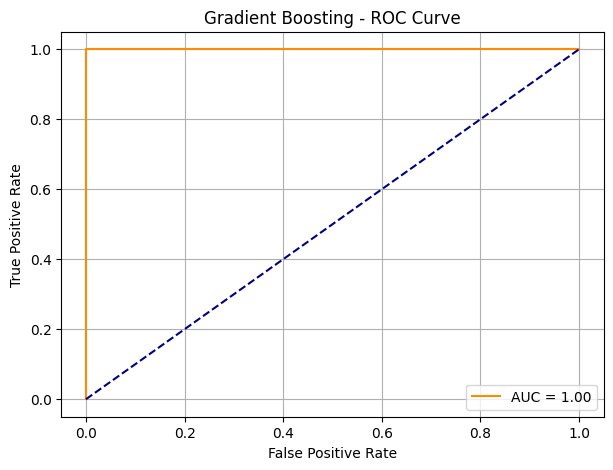

In [23]:
# 📊 Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# 📈 Predictions
gb_preds = gb_model.predict(X_test)
gb_probs = gb_model.predict_proba(X_test)[:, 1]

# 📊 Accuracy & Report
print("🔍 Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))
print(classification_report(y_test, gb_preds))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, gb_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Gradient Boosting - Confusion Matrix")
plt.show()

# 📊 ROC Curve
fpr, tpr, _ = roc_curve(y_test, gb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Gradient Boosting - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 236, number of negative: 1773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 2009, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117471 -> initscore=-2.016597
[LightGBM] [Info] Start training from score -2.016597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

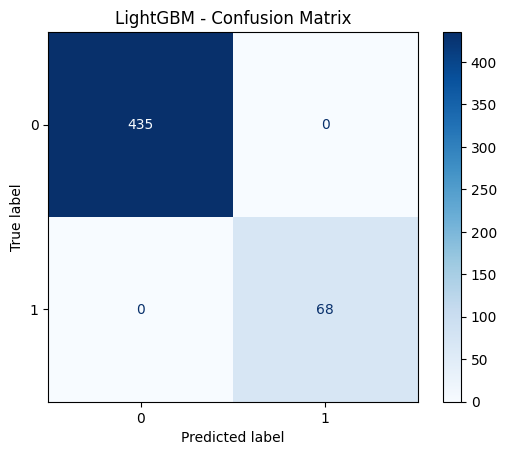

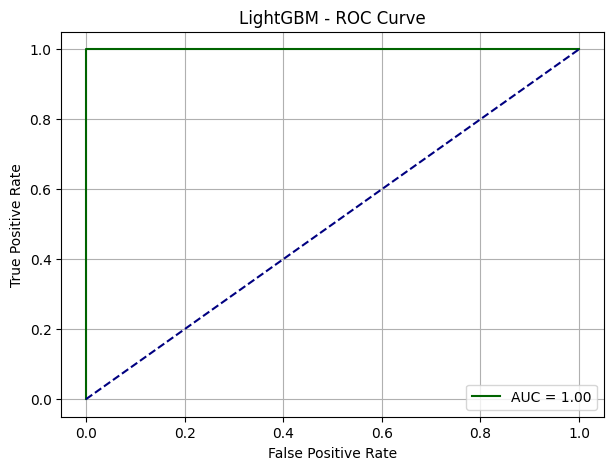

In [24]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
import lightgbm as lgb

# ⚙️ Assuming df_encoded is ready (your preprocessed dataset)
# X = df_encoded.drop('is_fraud', axis=1)
# y = df_encoded['is_fraud']

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train LightGBM Classifier
lgbm_model = lgb.LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# ✅ Predictions
lgbm_preds = lgbm_model.predict(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]

# ✅ Accuracy & Classification Report
print("🔍 LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, lgbm_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("LightGBM - Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, lgbm_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkgreen', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('LightGBM - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


🔍 Naive Bayes Accuracy: 0.7216699801192843
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       435
           1       0.25      0.54      0.35        68

    accuracy                           0.72       503
   macro avg       0.58      0.65      0.58       503
weighted avg       0.82      0.72      0.76       503



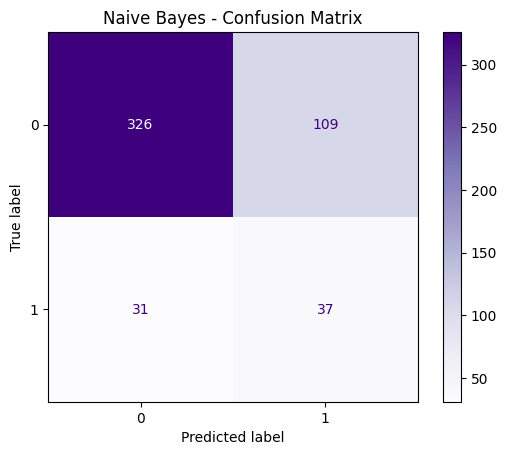

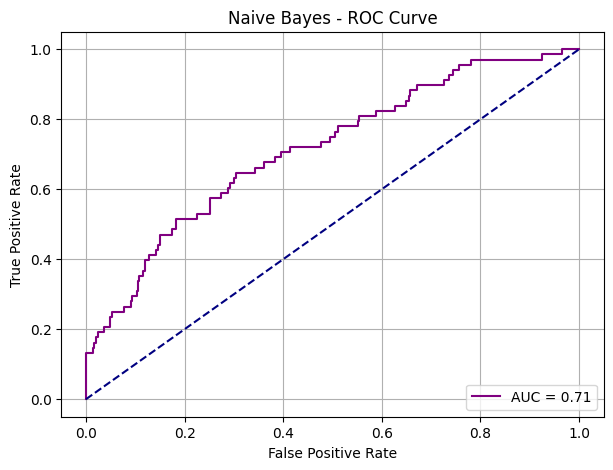

In [25]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.naive_bayes import GaussianNB

# ⚙️ Assuming df_encoded is ready (your preprocessed dataset)
# X = df_encoded.drop('is_fraud', axis=1)
# y = df_encoded['is_fraud']

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# ✅ Predictions
nb_preds = nb_model.predict(X_test)
nb_probs = nb_model.predict_proba(X_test)[:, 1]

# ✅ Accuracy & Classification Report
print("🔍 Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, nb_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Purples')
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, nb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='purple', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Naive Bayes - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [26]:
pip install joblib


In [27]:
import joblib


In [28]:
joblib.dump(nb_model, '/content/drive/MyDrive/Colab Notebooks/Fraud_Detection/fraud_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/Fraud_Detection/fraud_model.pkl']

In [29]:
import streamlit as st
import pandas as pd
import joblib

# Load trained model
model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Fraud_Detection/fraud_model.pkl')

# App title
st.title("🏦 Bank Fraud Detection App")

# Inputs
amount = st.number_input("Transaction Amount", min_value=0.0)
old_balance = st.number_input("Old Balance", min_value=0.0)
new_balance = st.number_input("New Balance", min_value=0.0)
transaction_type = st.selectbox("Transaction Type", ["TRANSFER", "CASH_OUT"])

# Encode transaction type
type_encoded = 0 if transaction_type == "TRANSFER" else 1

# Predict button
if st.button("Predict Fraud"):
    input_data = pd.DataFrame([[amount, old_balance, new_balance, type_encoded]],
                              columns=["amount", "oldbalanceOrg", "newbalanceOrig", "type_encoded"])
    prediction = model.predict(input_data)[0]

    if prediction == 1:
        st.error("⚠️ Fraud Detected!")
    else:
        st.success("✅ Transaction Safe.")


ModuleNotFoundError: No module named 'streamlit'